# The role of data scientists in building fairer machine learning 
## AIF360 Case study: Predictive risk assessment tool German Credit data set
Developed by Jurriaan Parie, Data scientist IBM Northern Europe. For questions please reach out to Jurriaan.Parie@ibm.com.

### Load libraries and helper code

In [1]:
import sys
sys.path.insert(0, "../")  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Dataset
from german_dataset import GermanDataset

# Helper functions
from helper_functions import *

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

np.random.seed(0)

### Loading data

In [2]:
gd = GermanDataset(
    
    # default pre-processing
    custom_preprocessing=default_preprocessing
)

Convert to pandas data frame.

In [3]:
df_gd = gd.convert_to_dataframe()[0]
df_gd.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


# Blog Part 1

### Explanatory data analysis – Percentage of defaults per age group

In [4]:
# create bins and labels
bins = [17,25,35,45,55,65,75]
labels = ["%s-%s" %(bins[idx-1]+1,bins[idx]) for idx in range(1,len(bins))]

# bin age colum
b = pd.cut(df_gd['age'], bins=bins, labels=labels, include_lowest=False)

# groupby age and credit column
df_grouped = df_gd.groupby(['credit', b]).size().unstack(fill_value=0).stack().reset_index(name='count')
df_grouped = df_grouped.groupby(['age','credit']).sum()
df_grouped

count
age   credit       
18-25 0.0       110
      1.0        80
26-35 0.0       280
      1.0       118
36-45 0.0       171
      1.0        55
46-55 0.0        87
      1.0        28
56-65 0.0        39
      1.0        14
66-75 0.0        13
      1.0         5

Compute proportion of defaulting applicants per age group. 

In [5]:
bin_default_dict = {}
bin_non_default_dict = {}

# iterate through age groups to compute default percentage
for label in labels:
    
    # number of defaulting applicants 
    n_default = df_grouped.loc[(label, 1.0)]['count']
    n_non_default = df_grouped.loc[(label, 0.0)]['count']
    
    # append to dictionary
    bin_default_dict["%s" %label] = str('{0:.0f}'.format((n_default/(n_default+n_non_default))*100)) + "%"
    bin_non_default_dict["%s" %label] = str('{0:.0f}'.format((n_non_default/(n_default+n_non_default))*100)) + "%"

bin_default_dict

{'18-25': '42%',
 '26-35': '30%',
 '36-45': '24%',
 '46-55': '24%',
 '56-65': '26%',
 '66-75': '28%'}

### Figure 1 – Stacked histogram

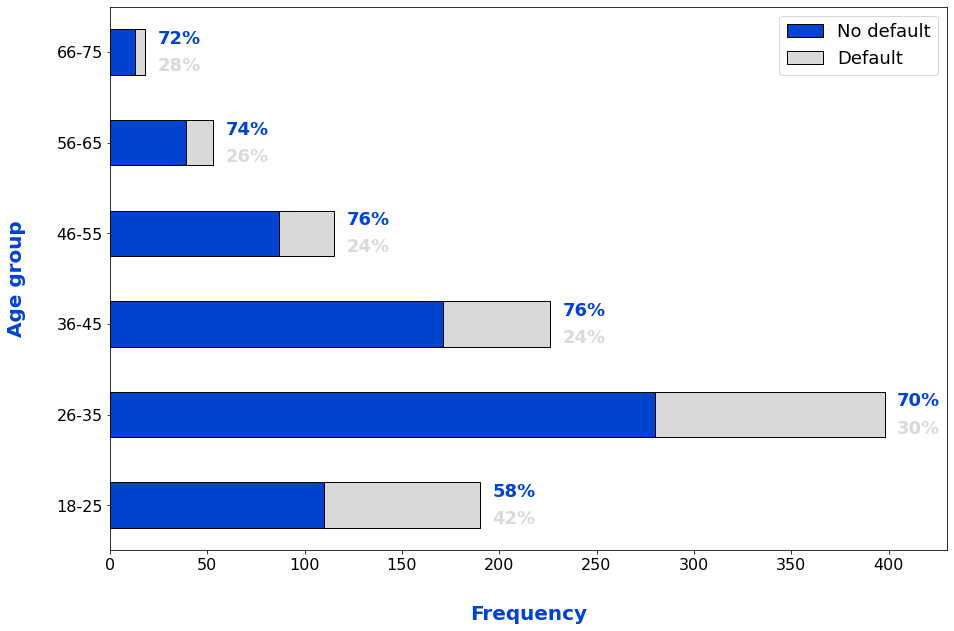

In [6]:
color_dark = "#0043CE"
color_light = "#D9D9D9"

# plot
fig, ax = plt.subplots(figsize=(15,10))
df_grouped.unstack().plot(kind='barh', stacked=True, ax=ax, color=[color_dark,color_light], edgecolor='k')

# x-axis
ax.set_xlabel("Frequency", fontsize=20, fontweight='bold', color=color_dark)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim([0,430])
ax.xaxis.set_label_coords(0.5, -0.1)

# y-axis
ax.set_ylabel("Age group", fontsize=20, fontweight='bold', color=color_dark)
ax.yaxis.set_label_coords(-0.1, 0.5)

# iterate through labels to annotate text
for i in range(0,6):
    label = labels[i]
    x_coord = df_grouped.loc[label]['count'].sum()
    y_coord = i
    
    # annotate text
    plt.text(x_coord+17.5, y_coord+0.05, bin_non_default_dict[label], ha="center", va="bottom", color=color_dark, fontsize=18, fontweight="bold")
    plt.text(x_coord+17.5, y_coord-0.25, bin_default_dict[label], ha="center", va="bottom", color=color_light, fontsize=18, fontweight="bold")

# legend
ax.legend(['No default','Default'], fontsize=18)
    
plt.show()

### Initialize (un)priviliged groups and split original data set

In [7]:
# age as protected attribute
prot_attr = 'age'
age_level = 25

# (un)priviliged groups
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

# pre-processing data set AIF360
gd = GermanDataset(
    
    # specify protected attribute
    protected_attribute_names=[prot_attr],

    # initialize priviliged class            
    privileged_classes=[lambda x: x > age_level],

    # default pre-processing
    custom_preprocessing=default_preprocessing
)

# split data
gd_train, gd_val, gd_test = gd.split([0.5, 0.8], shuffle=True)

### Table 1 – Number of (un)favourable and (un)priviliged applicants

In [8]:
# convert training data to pandas data frame
df_gd_train = gd_train.convert_to_dataframe()[0]

## unfavourable and priviliged 
a = df_gd_train[(df_gd_train['credit']==1.0) & (df_gd_train['age']==1.0)].shape[0]
print(a) 

## favourable and priviliged 
b = df_gd_train[(df_gd_train['credit']==0.0) & (df_gd_train['age']==1.0)].shape[0]
print(b) 

## unfavourable and unpriviliged 
c = df_gd_train[(df_gd_train['credit']==1.0) & (df_gd_train['age']==0.0)].shape[0]
print(c) 

## favourable and unpriviliged 
d = df_gd_train[(df_gd_train['credit']==0.0) & (df_gd_train['age']==0.0)].shape[0]
print(d) 

print("Total: " + str(a+b+c+d))

p1 = b/(a+b)
p2 = d/(c+d)

p3 = a/(a+b)
p4 = c/(c+d)

print("Stat. diff. par.: " + str(p1 - p2))
print("Disprate impact: " + str(p2/p1))

105
291
45
59
Total: 500
Stat. diff. par.: 0.16754079254079257
Disprate impact: 0.7720063441712925


### Compute fairness metrics based on observed favorable outcomes in original data set

In [9]:
# compute metrics
metric_gd_train = BinaryLabelDatasetMetric(gd_train, 
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)

# statistical parity difference
print("Statistical parity difference = %f" %metric_gd_train.statistical_parity_difference())

# disparate impact
print("Disparate impact = %f" %metric_gd_train.disparate_impact())

Statistical parity difference = -0.167541
Disparate impact = 0.772006


# Blog Part 2

## Model training

### Strategy 1 – Excluding protected attribute `age` before training

Remove `age` from train data features.

In [10]:
gd_train1 = gd_train.copy()

# delete age column from features
gd_train1.features = np.delete(gd_train1.features, 4, 1)

Train model on adjusted data.

In [11]:
# initialize pipeline
model1 = make_pipeline(StandardScaler(),
                       LogisticRegression(solver='liblinear', random_state=1))

# model parameters
fit_params = {'logisticregression__sample_weight': gd_train1.instance_weights}

# fit model
LR1 = model1.fit(gd_train1.features, gd_train1.labels.ravel(), **fit_params)

Add variable `age` as a dummy variable with coefficient `0`. We do this to keep `age` in the data set to track (un)priviliged groups.

In [12]:
coef1_train = model1.steps[1][1].coef_[0]
coef1 = np.insert(coef1_train, 4, 0)

Print coefficients of LR model.

In [13]:
intercept1 = model1.steps[1][1].intercept_
print("Intercept: ", intercept1)

coef_dict1 = {}
for feat, val in zip(gd_train1.feature_names,coef1):
    coef_dict1[feat] = val
coef_dict1

Intercept:  [-1.23950787]


{'month': 0.331580985306901,
 'credit_amount': 0.23957636259665455,
 'investment_as_income_percentage': 0.3309024080949382,
 'residence_since': 0.06399253716521079,
 'age': 0.0,
 'number_of_credits': 0.05064140234281993,
 'people_liable_for': 0.01897964310912125,
 'status=A11': 0.22575921292186982,
 'status=A12': 0.294547355953449,
 'status=A13': 0.05254033466607655,
 'status=A14': -0.4897328217525122,
 'credit_history=A30': 0.1344084908028544,
 'credit_history=A31': 0.15373667845091213,
 'credit_history=A32': 0.14948882747230052,
 'credit_history=A33': -0.03614724099735195,
 'credit_history=A34': -0.28580913511555406,
 'purpose=A40': 0.27685593980968903,
 'purpose=A41': -0.17183945564662237,
 'purpose=A410': -0.1071961086417534,
 'purpose=A42': -0.020019119831580143,
 'purpose=A43': -0.14686500288490673,
 'purpose=A44': 0.04309058201537904,
 'purpose=A45': -0.04208347997776027,
 'purpose=A46': 0.26223560097857723,
 'purpose=A48': -0.30012307685175715,
 'purpose=A49': -0.06070141135442

### Strategy 2 – Changing model parameter after training

Train model on original data.

In [14]:
gd_train2 = gd_train.copy()

# initialize pipeline
model2 = make_pipeline(StandardScaler(),
                       LogisticRegression(solver='liblinear', random_state=1))

# model parameters
fit_params = {'logisticregression__sample_weight': gd_train2.instance_weights}

# fit model
LR2 = model2.fit(gd_train2.features, gd_train2.labels.ravel(), **fit_params)

Set regression coefficient of `age` to 0.

In [15]:
intercept2 = model2.steps[1][1].intercept_
coef2 = model2.steps[1][1].coef_[0]

print("Intercept: ", intercept2)

coef_dict2 = {}
for feat, val in zip(gd_train2.feature_names,coef2):
    coef_dict2[feat] = val
coef_dict2['age'] = 0
coef_dict2

Intercept:  [-1.2461668]


{'month': 0.3440460510438196,
 'credit_amount': 0.2251679608425539,
 'investment_as_income_percentage': 0.34112384954167346,
 'residence_since': 0.05982068956547838,
 'age': 0,
 'number_of_credits': 0.04763988506272798,
 'people_liable_for': 0.05674929344488844,
 'status=A11': 0.21654708158228345,
 'status=A12': 0.27669874149500906,
 'status=A13': 0.07054322968840596,
 'status=A14': -0.4743552955592983,
 'credit_history=A30': 0.1402264620461303,
 'credit_history=A31': 0.15096057587508172,
 'credit_history=A32': 0.13096593982122465,
 'credit_history=A33': -0.01784207934519872,
 'credit_history=A34': -0.2763902648968066,
 'purpose=A40': 0.28350357895155354,
 'purpose=A41': -0.1790120788465061,
 'purpose=A410': -0.09861195504654795,
 'purpose=A42': -0.026149863083494318,
 'purpose=A43': -0.1648286476390503,
 'purpose=A44': 0.04332962940456892,
 'purpose=A45': -0.04055448847926406,
 'purpose=A46': 0.2716380329823711,
 'purpose=A48': -0.2924223463357255,
 'purpose=A49': -0.04005614167589722

## Model performance: Accuracy

### Strategy 1

In [16]:
# specify candidate threshold
thresh_arr = np.linspace(0.5, 1, 50)

# compute model metrics
metrics1 = test_model(dataset=gd_val,
                      coef=coef1,
                      intercept=intercept1,
                      thresh_arr=thresh_arr,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

### Strategy 2

In [17]:
# specify candidate threshold
thresh_arr = np.linspace(0.5, 1, 50)

# compute model metrics
metrics2 = test_model(dataset=gd_val,
                      coef=coef2,
                      intercept=intercept2,
                      thresh_arr=thresh_arr,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

Plot model accuracy as a function of classification threshold on the validation set.

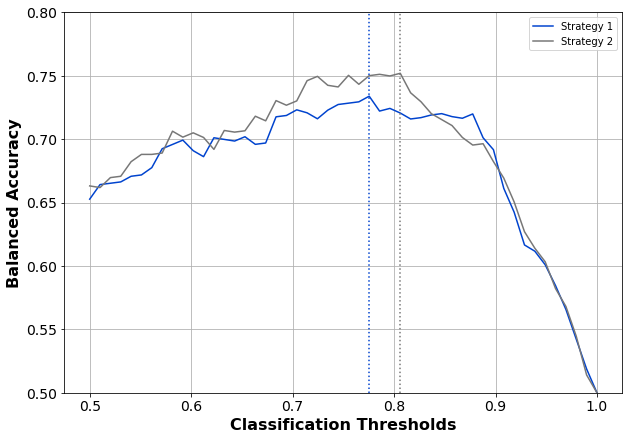

In [18]:
# threshold with highest balanced accuracy
LR1_best_ind = np.argmax(metrics1['bal_acc'])
LR2_best_ind = np.argmax(metrics2['bal_acc'])

# plot function
plot(thresh_arr,                        # threshold
     'Classification Thresholds',       # x-asis name
     metrics1['bal_acc'],               # variable left y-axis
     'Balanced Accuracy',               # name left y-axis
     [0.50,0.80],                       # left y-axis limits 
     second_plot=metrics2['bal_acc']    # variable left y-axis
)

Model accuracy maximizing thresholds.

In [19]:
print("Best threshold Strategy 1: ", thresh_arr[LR1_best_ind])
print("Best threshold Strategy 2: ", thresh_arr[LR2_best_ind])

Best threshold Strategy 1:  0.7755102040816326
Best threshold Strategy 2:  0.8061224489795917


Highest model accuracy.

In [20]:
print("Balanced accuracy Strategy 1: ", metrics1['bal_acc'][LR1_best_ind])
print("Balanced accuracy Strategy 2: ", metrics2['bal_acc'][LR2_best_ind])

Balanced accuracy Strategy 1:  0.7338513841670714
Balanced accuracy Strategy 2:  0.751902217905132


## Model performance – Fairness metrics

### Strategy 1 – Statistical parity difference

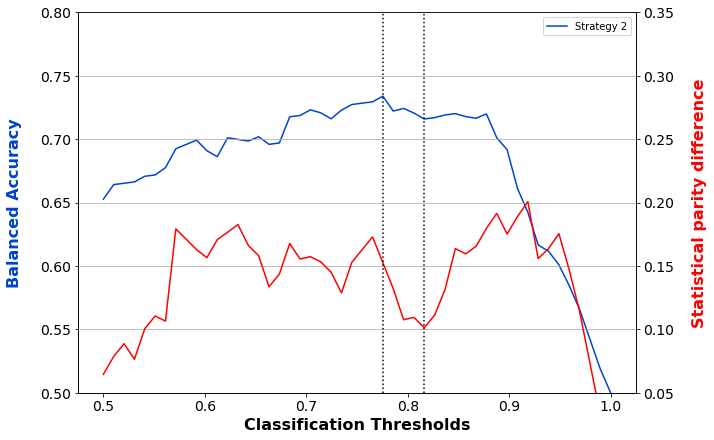

In [27]:
# plot function
plot_acc_fair(thresh_arr,                                   # threshold
              'Classification Thresholds',                  # x-asis name
              metrics1['bal_acc'],                          # variable left y-axis
              'Balanced Accuracy',                          # name left y-axis
              metrics1['stat_par_diff'],                    # variable right y-axis
              'Statistical parity difference',              # name right y-axis
              [0.50,0.80],                                  # left y-axis limits 
              [0.05,0.35],                                  # right y-axis limits 
              thres = [thresh_arr[31]],                     # comparative threshold
              color='color_dark')                           # color of plot                    

### Strategy 1 – Disparate impact

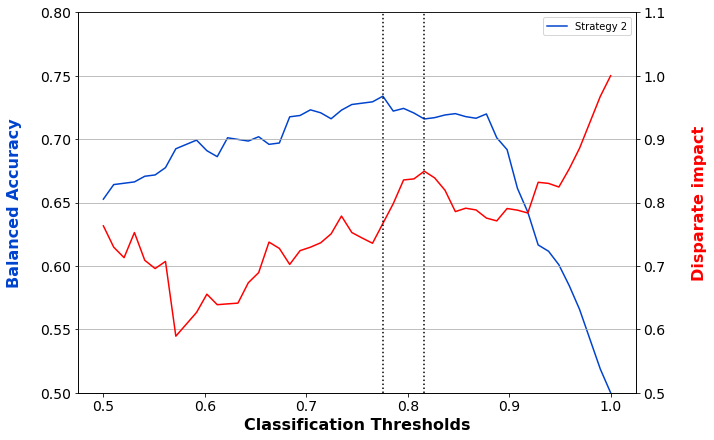

In [28]:
# calculate disparate impact measure 
disp_imp1 = np.array(metrics1['disp_imp'])
disp_imp1 = 1/disp_imp1

# plot function
plot_acc_fair(thresh_arr,                                    # threshold
              'Classification Thresholds',                   # x-asis name
               metrics1['bal_acc'],                          # variable left y-axis
               'Balanced Accuracy',                          # name left y-axis
               disp_imp1,                                    # variable right y-axis
               'Disparate impact',                           # name right y-axis
               [0.50,0.80],                                  # left y-axis limits 
               [0.5,1.1],                                    # right y-axis limits 
               thres=[thresh_arr[31]],                       # comparative threshold
               color='color_dark')                           # color of plot

Accuracy and fairness metrics for model accuracy maximizing threshold.

In [29]:
print("Threshold: ", thresh_arr[LR1_best_ind])
print("Balanced accuracy: ", metrics1['bal_acc'][LR1_best_ind])
print("Statistical parity difference: ", metrics1['stat_par_diff'][LR1_best_ind])
print("Disparate impact: ", disp_imp1[LR1_best_ind])

Threshold:  0.7755102040816326
Balanced accuracy:  0.7338513841670714
Statistical parity difference:  0.1525046382189239
Disparate impact:  0.7670068027210885


Accuracy and fairness metrics for candidate threshold.

In [30]:
print("Threshold: ", thresh_arr[31])
print("Balanced accuracy: ", metrics1['bal_acc'][31])
print("Statistical parity difference: ", metrics1['stat_par_diff'][31])
print("Disparate impact: ", disp_imp1[31])

Threshold:  0.8163265306122449
Balanced accuracy:  0.7158814958717824
Statistical parity difference:  0.10129870129870133
Disparate impact:  0.8494208494208494


### Strategy 2 – Statistical parity difference

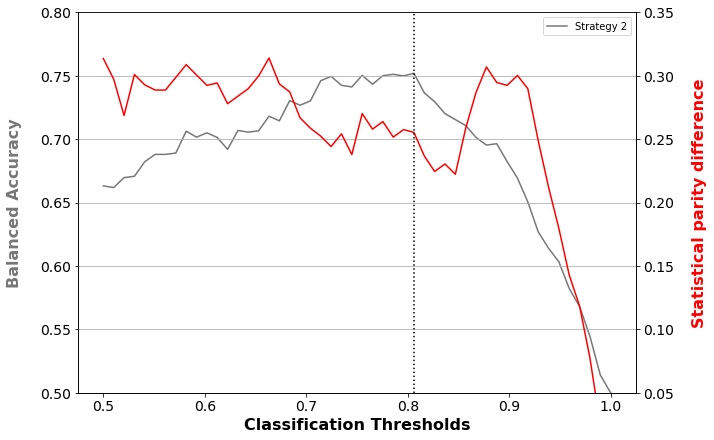

In [32]:
# plot function
plot_acc_fair(thresh_arr,                                   # threshold
              'Classification Thresholds',                  # x-asis name
              metrics2['bal_acc'],                          # variable left y-axis
              'Balanced Accuracy',                          # name left y-axis
              metrics2['stat_par_diff'],                    # variable right y-axis
              'Statistical parity difference',              # name right y-axis
              [0.50,0.80],                                  # left y-axis limits 
              [0.05,0.35],                                  # right y-axis limits 
              thres = [],                                   # comparative threshold
              color='color_light')                          # color of plot

### Strategy 2 – Disparate impact

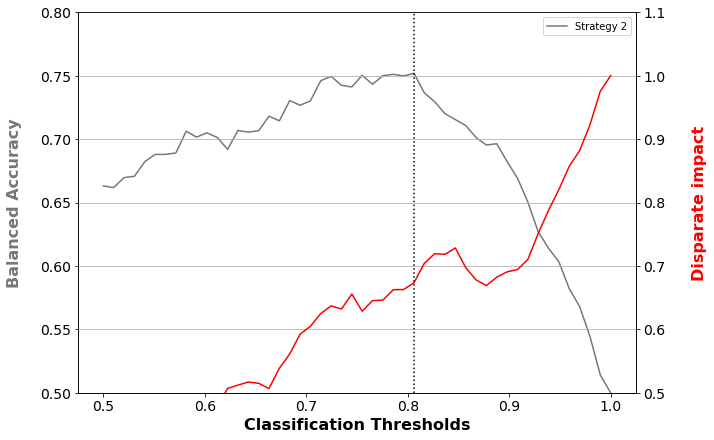

In [33]:
# calculate disparate impact measure 
disp_imp2 = np.array(metrics2['disp_imp'])
disp_imp2 = 1/disp_imp2

# plot function
plot_acc_fair(thresh_arr,                                    # threshold
              'Classification Thresholds',                   # x-asis name
               metrics2['bal_acc'],                          # variable left y-axis
               'Balanced Accuracy',                          # name left y-axis
               disp_imp2,                                    # variable right y-axis
               'Disparate impact',                           # name right y-axis
               [0.50,0.80],                                  # left y-axis limits 
               [0.5,1.1],                                    # right y-axis limits 
               thres = [],                                   # comparative threshold
               color='color_light')                          # color of plot

Accuracy and fairness metrics for model accuracy maximizing threshold.

In [36]:
print("Threshold: ", thresh_arr[LR2_best_ind])
print("Balanced accuracy: ", metrics2['bal_acc'][LR2_best_ind])
print("Statistical parity difference: ", metrics2['stat_par_diff'][LR2_best_ind])
print("Disparate impact: ", disp_imp2[LR2_best_ind])

Threshold:  0.8061224489795917
Balanced accuracy:  0.751902217905132
Statistical parity difference:  0.2552875695732839
Disparate impact:  0.673469387755102
